# Train Test Split on SMOTED Training Data
## Logistic Regression
## 1 TF-IDF

In [1]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
# need to 'pip install vega' before using renderer
#alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import shuffle
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
%matplotlib inline
#fix random seed
np.random.seed(1)

Using TensorFlow backend.


In [2]:
TRAINING_FILE = "../keyword.csv"
TEST_FILE = "../key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
df_train.head(5)

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


,Unnamed: 0,article_number,article_words,topic,IR_binary,key_word_10,key_word_20,key_word_50,key_word_100
0,0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,False,"stock,rate,defend,bank,bank,bank,bank,bank,dol...","cent,cent,cent,stock,rate,end,won,won,won,won,...","open,cent,cent,cent,stock,rate,end,won,won,won...","open,cent,cent,cent,stock,rate,end,won,won,won..."
1,1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,False,"day,day,day,bank,year,dollar,dollar,deal,deal,...","end,end,day,day,day,point,time,bank,year,dolla...","end,end,day,day,day,point,time,bank,early,year...","end,end,day,day,day,index,point,time,busi,bank..."
2,2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,False,"world,world,stat,stat,stat,stat,year,releas,re...","world,world,stat,stat,stat,stat,govern,time,ye...","socc,socc,world,world,stat,stat,stat,stat,gove...","socc,socc,world,world,recent,law,stat,stat,sta..."
3,3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,False,"play,bank,bank,mark,mark,percent,percent,perce...","cent,cent,end,play,unit,bank,bank,mark,mark,pe...","open,cent,cent,end,play,unit,made,bank,bank,tu...","open,cent,cent,end,play,unit,made,bank,bank,ra..."
4,4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,True,day,"day,time,season,clos","minut,minut,minut,day,friday,friday,race,time,...","minut,minut,minut,day,friday,friday,race,time,..."


In [3]:
def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])

def save_variable(variable,filename):
    file_name = "Models/"+filename+".joblib"
    if not os.path.exists(file_name):
    # Export the model (TFIDF+logistic regressor)
        with open(file_name, "wb") as file:
            dump(variable, file, compress=True)
    else:
        print("Warn: this model already exits...")
        
def retrieve_variable(filename):
    file_name = "Models/"+filename+".joblib"
    return(load(file_name))

def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
def grid_search(vectorizer,model,train_x,train_y,topics):
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    estimators = [
                ("vectorizer",vectorizer),
                ("model",model)
                  ]
    pipe = Pipeline(estimators)

    param_grid = {
#                 "vectorizer__min_df":[i for i in range(1,6)],
                "model__C":[0.0001,0.01,0.1,1,10,100],
                "model__multi_class":['ovr', 'multinomial'],
                "model__solver": ['lbfgs', 'liblinear', 'sag']
                 }
    grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)
    grid_result=grid_search.fit(train_x, train_y)
    return grid_result
    
def test_model(df_test,model,le,encode_mapping):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(test_x)
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in model.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()



In [4]:
# get train_x and train_y
new_df = shuffle(df_train,random_state=42).dropna().apply(lambda x: x.replace('_', ''))
train_x = new_df.article_words
train_y = new_df.topic
le = preprocessing.LabelEncoder()
le.fit(train_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
en_train_y = le.transform(train_y)
topics = list(set(new_df['topic']))
# Using SMOTE to solve imbalance
smote = SMOTE(random_state=1)
vectorizer = TfidfVectorizer()
vectorizer.fit(train_x)
train_vectors = vectorizer.transform(train_x)
smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
new_train_x = vectorizer.inverse_transform(smo_x)
new_train_x = pd.Series([','.join(item) for item in new_train_x])

In [5]:
train_x_10 = new_df.key_word_10
vectorizer.fit(train_x_10)
train_vectors_10 = vectorizer.transform(train_x_10)
smo_x_10,smo_y = smote.fit_sample(train_vectors_10,en_train_y)
new_train_x_10 = vectorizer.inverse_transform(smo_x_10)
new_train_x_10 = pd.Series([','.join(item) for item in new_train_x_10])

In [6]:
train_x_20 = new_df.key_word_20
vectorizer.fit(train_x_20)
train_vectors_20 = vectorizer.transform(train_x_20)
smo_x_20,smo_y = smote.fit_sample(train_vectors_20,en_train_y)
new_train_x_20 = vectorizer.inverse_transform(smo_x_20)
new_train_x_20 = pd.Series([','.join(item) for item in new_train_x_20])

In [7]:
train_x_50 = new_df.key_word_50
vectorizer.fit(train_x_50)
train_vectors_50 = vectorizer.transform(train_x_50)
smo_x_50,smo_y = smote.fit_sample(train_vectors_50,en_train_y)
new_train_x_50 = vectorizer.inverse_transform(smo_x_50)
new_train_x_50 = pd.Series([','.join(item) for item in new_train_x_50])

In [8]:
train_x_100 = new_df.key_word_100
vectorizer.fit(train_x_100)
train_vectors_100 = vectorizer.transform(train_x_100)
smo_x_100,smo_y = smote.fit_sample(train_vectors_100,en_train_y)
new_train_x_100 = vectorizer.inverse_transform(smo_x_100)
new_train_x_100 = pd.Series([','.join(item) for item in new_train_x_100])

In [9]:
train_x,valid_x,train_y,valid_y = train_test_split(new_train_x,smo_y,test_size=0.3,random_state=42)
valid_size = valid_x.shape[0]
train_x_10,valid_x_10,train_y,valid_y = train_test_split(new_train_x_10,smo_y,test_size=0.3,random_state=42)
train_x_20,valid_x_20,train_y,valid_y = train_test_split(new_train_x_20,smo_y,test_size=0.3,random_state=42)
train_x_50,valid_x_50,train_y,valid_y = train_test_split(new_train_x_50,smo_y,test_size=0.3,random_state=42)
train_x_100,valid_x_100,train_y,valid_y = train_test_split(new_train_x_100,smo_y,test_size=0.3,random_state=42)
print(valid_size)
print(valid_x_10.shape)

15504
(15504,)


In [10]:
train_collection = {
    'train10': train_x_10,
    'train20': train_x_20,
    'train50': train_x_50,
    'train100': train_x_100,
    'trainfull': train_x,
}

valid_collection = {
    'valid10': valid_x_10,
    'valid20': valid_x_20,
    'valid50': valid_x_50,
    'valid100': valid_x_100,
    'validfull': valid_x,
}

In [11]:
def get_model(df_name, x, y):
    # Start grid search
    grid_count = grid_search(CountVectorizer(),LogisticRegression(),\
                                                  x,y,topics)
    grid_tfidf = grid_search(TfidfVectorizer(norm=None),LogisticRegression(),\
                                                  x,y,topics)
    
    count_clf_logi,count_clf_accuracy = grid_count.best_estimator_, grid_count.best_score_
    tfidf_clf_logi,tfidf_clf_accuracy = grid_tfidf.best_estimator_, grid_tfidf.best_score_
    
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        # Export the better model
        save_variable(grid_count, f"count+{df_name}_smotwithtfidf")
        print(f'*************************************************************')
        print(f'Now the training set is {df_name}, and the model chosen is count_clf_logi')
        print(f'The accuracy is {count_clf_accuracy}')
        return count_clf_logi
    else:
        save_variable(grid_tfidf, f"tfidf+{df_name}_smotwithtfidf")
        print(f'*************************************************************')
        print(f'Now the training set is {df_name}, and the model chosen is tfidf_clf_logi')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return tfidf_clf_logi
    

In [12]:
# %%time
# rev_valid_y = le.inverse_transform(valid_y)
# for train_name, x_train in train_collection.items():
#     clf_logi,le,encode_mapping = get_model(x_name, x_train, train_y)
#     for valid_name, x_valid in valid_collection.items():
#         if (x_valid.isnull().values.any()):
#             continue
#         print('----------------------------------------------------------------------')
#         print(f'Now, the train_df is {train_name}, the validation_df is {valid_name}')
#         df_valid = pd.DataFrame({'key_word':x_valid,'topic':rev_valid_y})
#         test_model(df_valid,clf_logi,le,encode_mapping)

*************************************************************
Now the training set is train10, and the model chosen is count_clf_logi
The accuracy is 0.8321994533827957
----------------------------------------------------------------------
Now, the train_df is train10, the validation_df is valid10
F1 score for  Pipeline  model is  0.8315632294925894
Accuracy score for  Pipeline  model is  0.8328173374613003
Recall score for  Pipeline  model is  0.8334167573997159 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1381
           1       0.77      0.79      0.78      1408
           2       0.93      0.91      0.92      1414
           3       0.95      0.98      0.96   

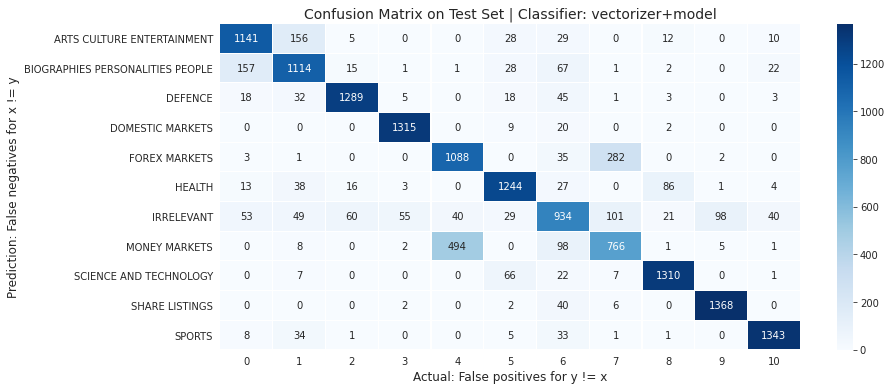

----------------------------------------------------------------------
Now, the train_df is train10, the validation_df is valid20
F1 score for  Pipeline  model is  0.838806315055573
Accuracy score for  Pipeline  model is  0.8406217750257998
Recall score for  Pipeline  model is  0.8411692470638763 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1381
           1       0.79      0.83      0.81      1408
           2       0.92      0.94      0.93      1414
           3       0.95      0.97      0.96      1346
           4       0.66      0.77      0.71      1411
           5       0.88      0.86      0.87      1432
           6       0.74      0.63      0.68      1480


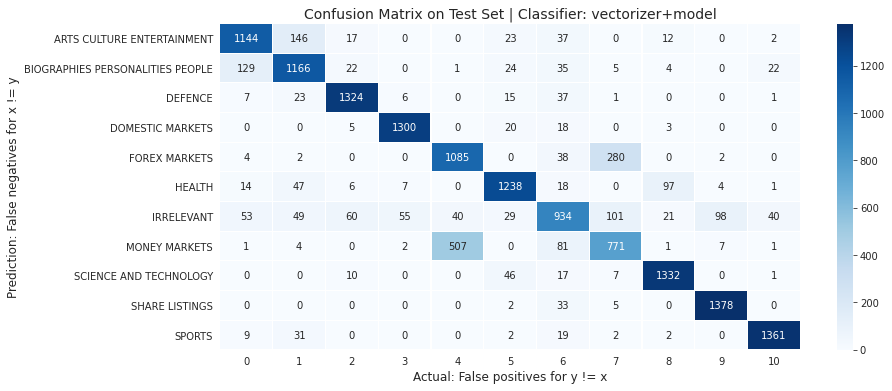

----------------------------------------------------------------------
Now, the train_df is train10, the validation_df is valid50
F1 score for  Pipeline  model is  0.8377774216835063
Accuracy score for  Pipeline  model is  0.8397832817337462
Recall score for  Pipeline  model is  0.8402974930013829 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1381
           1       0.82      0.83      0.82      1408
           2       0.92      0.94      0.93      1414
           3       0.94      0.95      0.95      1346
           4       0.66      0.77      0.71      1411
           5       0.87      0.86      0.87      1432
           6       0.75      0.63      0.68      1480

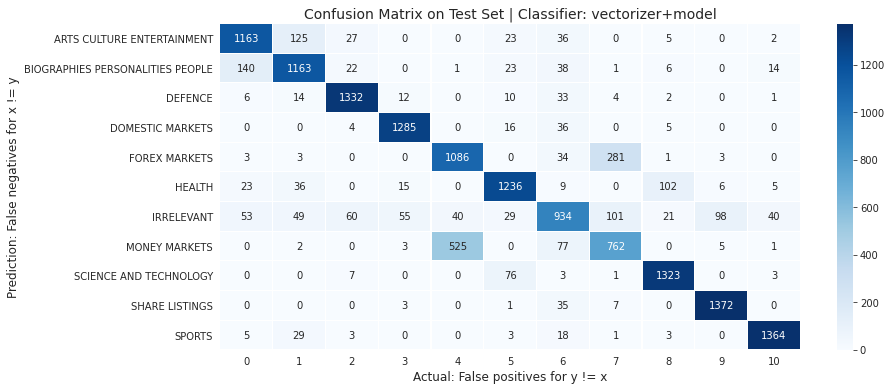

----------------------------------------------------------------------
Now, the train_df is train10, the validation_df is valid100
F1 score for  Pipeline  model is  0.8373786327610571
Accuracy score for  Pipeline  model is  0.8393962848297214
Recall score for  Pipeline  model is  0.8399934844573618 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1381
           1       0.81      0.83      0.82      1408
           2       0.91      0.93      0.92      1414
           3       0.93      0.96      0.95      1346
           4       0.66      0.78      0.71      1411
           5       0.87      0.85      0.86      1432
           6       0.76      0.63      0.69      148

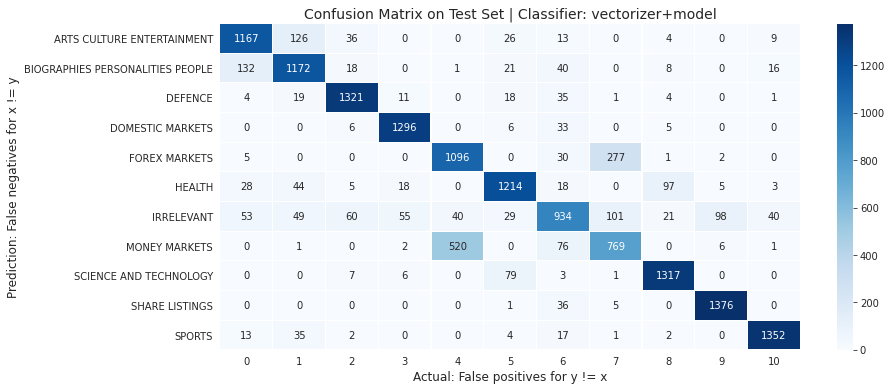

----------------------------------------------------------------------
Now, the train_df is train10, the validation_df is validfull
F1 score for  Pipeline  model is  0.8333247509429921
Accuracy score for  Pipeline  model is  0.8351393188854489
Recall score for  Pipeline  model is  0.8357222060578569 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1381
           1       0.80      0.84      0.82      1408
           2       0.91      0.92      0.91      1414
           3       0.94      0.97      0.95      1346
           4       0.66      0.78      0.71      1411
           5       0.84      0.85      0.84      1432
           6       0.74      0.63      0.68      14

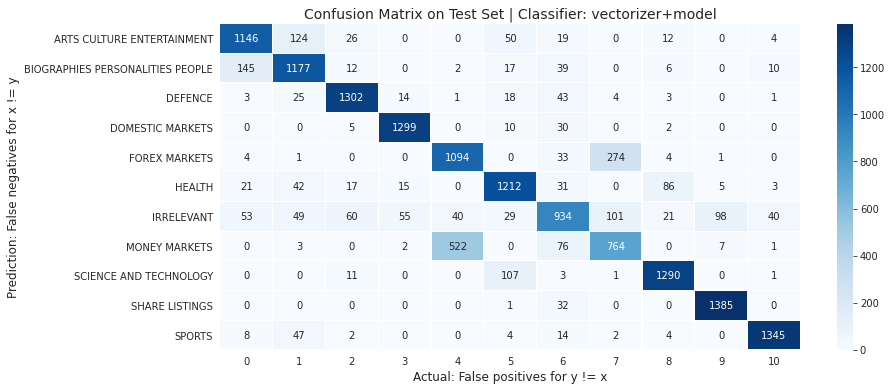

*************************************************************
Now the training set is train20, and the model chosen is tfidf_clf_logi
The accuracy is 0.8933762438384063
----------------------------------------------------------------------
Now, the train_df is train20, the validation_df is valid10
F1 score for  Pipeline  model is  0.7245456736600464
Accuracy score for  Pipeline  model is  0.719749742002064
Recall score for  Pipeline  model is  0.7198050957825186 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1381
           1       0.66      0.52      0.58      1408
           2       0.94      0.81      0.87      1414
           3       0.83      0.95      0.89    

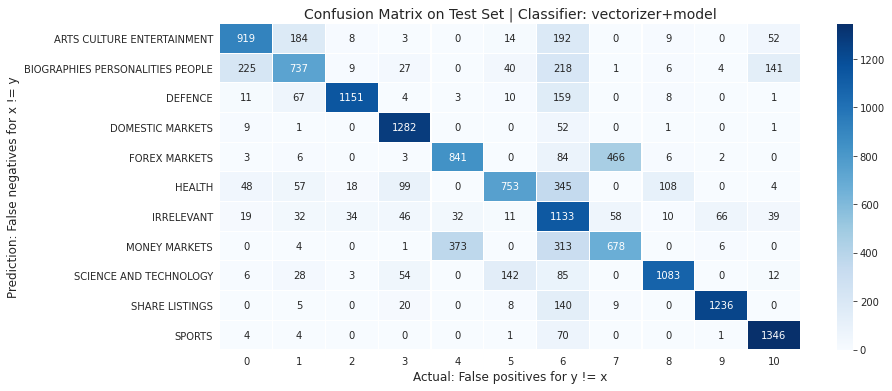

----------------------------------------------------------------------
Now, the train_df is train20, the validation_df is valid20
F1 score for  Pipeline  model is  0.890130582328982
Accuracy score for  Pipeline  model is  0.8914473684210527
Recall score for  Pipeline  model is  0.8918739869342737 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1381
           1       0.89      0.92      0.91      1408
           2       0.96      0.95      0.96      1414
           3       0.97      0.99      0.98      1346
           4       0.68      0.78      0.73      1411
           5       0.97      0.99      0.98      1432
           6       0.79      0.70      0.74      1480


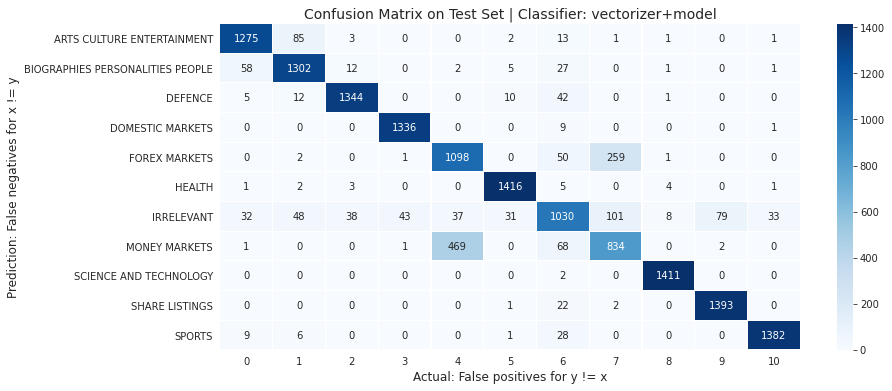

----------------------------------------------------------------------
Now, the train_df is train20, the validation_df is valid50
F1 score for  Pipeline  model is  0.8866144253151912
Accuracy score for  Pipeline  model is  0.8880288957688338
Recall score for  Pipeline  model is  0.8884391374995043 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1381
           1       0.91      0.90      0.90      1408
           2       0.96      0.96      0.96      1414
           3       0.96      0.99      0.98      1346
           4       0.68      0.78      0.72      1411
           5       0.96      0.98      0.97      1432
           6       0.80      0.70      0.74      1480

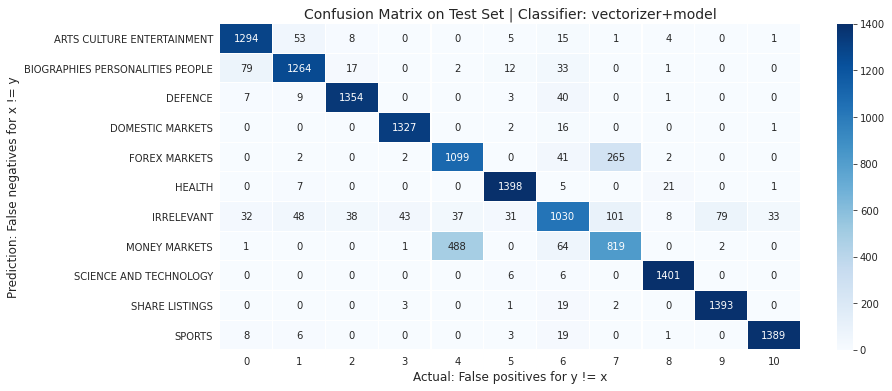

----------------------------------------------------------------------
Now, the train_df is train20, the validation_df is valid100
F1 score for  Pipeline  model is  0.8828088593279382
Accuracy score for  Pipeline  model is  0.8840944272445821
Recall score for  Pipeline  model is  0.8844787475092548 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1381
           1       0.89      0.90      0.90      1408
           2       0.95      0.95      0.95      1414
           3       0.96      0.99      0.97      1346
           4       0.68      0.78      0.73      1411
           5       0.95      0.97      0.96      1432
           6       0.79      0.70      0.74      148

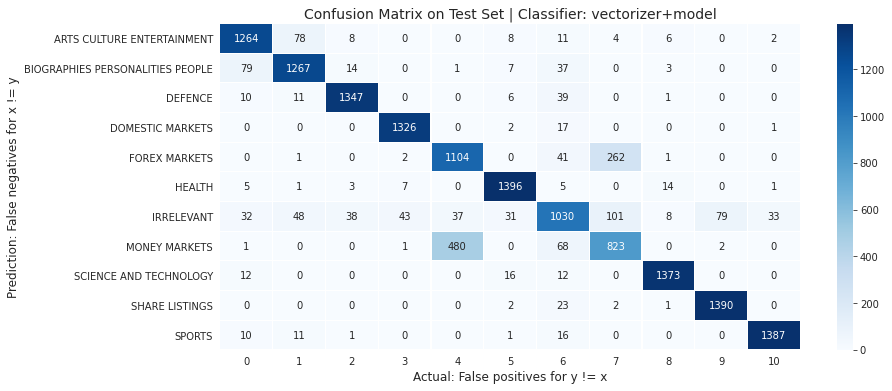

----------------------------------------------------------------------
Now, the train_df is train20, the validation_df is validfull
F1 score for  Pipeline  model is  0.8886725250815032
Accuracy score for  Pipeline  model is  0.8900928792569659
Recall score for  Pipeline  model is  0.8904873036310121 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1381
           1       0.91      0.92      0.92      1408
           2       0.96      0.95      0.95      1414
           3       0.97      0.99      0.98      1346
           4       0.69      0.79      0.74      1411
           5       0.96      0.98      0.97      1432
           6       0.80      0.70      0.74      14

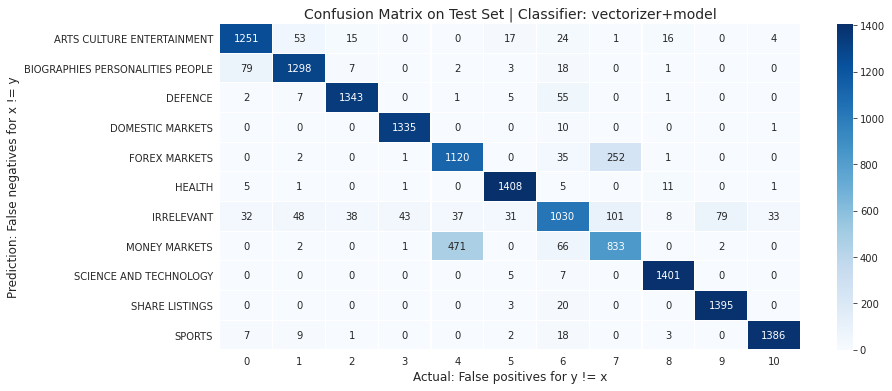

*************************************************************
Now the training set is train50, and the model chosen is tfidf_clf_logi
The accuracy is 0.9283739811677949
----------------------------------------------------------------------
Now, the train_df is train50, the validation_df is valid10
F1 score for  Pipeline  model is  0.5104490875262333
Accuracy score for  Pipeline  model is  0.4871001031991744
Recall score for  Pipeline  model is  0.48665126627138816 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.37      0.53      1381
           1       0.67      0.44      0.53      1408
           2       0.98      0.24      0.38      1414
           3       0.71      0.78      0.74  

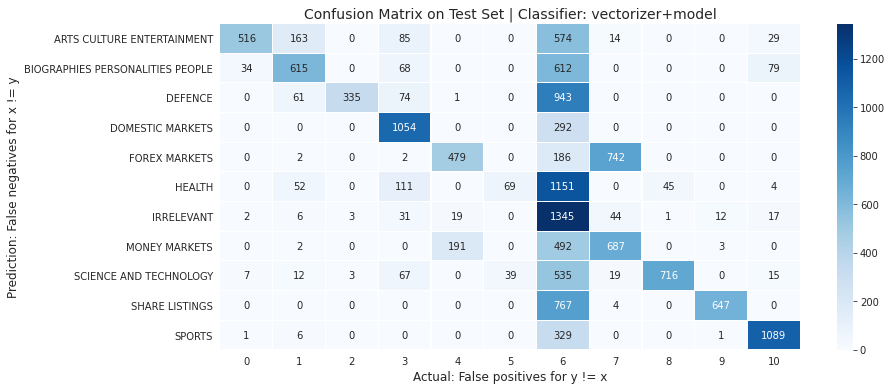

----------------------------------------------------------------------
Now, the train_df is train50, the validation_df is valid20
F1 score for  Pipeline  model is  0.7136348554693782
Accuracy score for  Pipeline  model is  0.6773090815273478
Recall score for  Pipeline  model is  0.6756051210586261 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74      1381
           1       0.77      0.68      0.72      1408
           2       0.98      0.53      0.69      1414
           3       0.94      0.61      0.74      1346
           4       0.70      0.61      0.65      1411
           5       0.92      0.62      0.74      1432
           6       0.27      0.89      0.42      1480

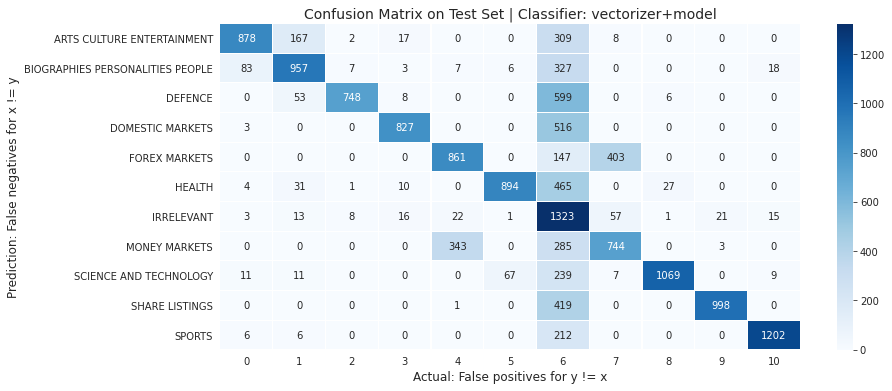

----------------------------------------------------------------------
Now, the train_df is train50, the validation_df is valid50
F1 score for  Pipeline  model is  0.9253028501230499
Accuracy score for  Pipeline  model is  0.925954592363261
Recall score for  Pipeline  model is  0.9261826072296614 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1381
           1       0.97      0.99      0.98      1408
           2       0.97      0.98      0.97      1414
           3       0.98      1.00      0.99      1346
           4       0.72      0.81      0.76      1411
           5       0.99      0.99      0.99      1432
           6       0.87      0.79      0.83      1480


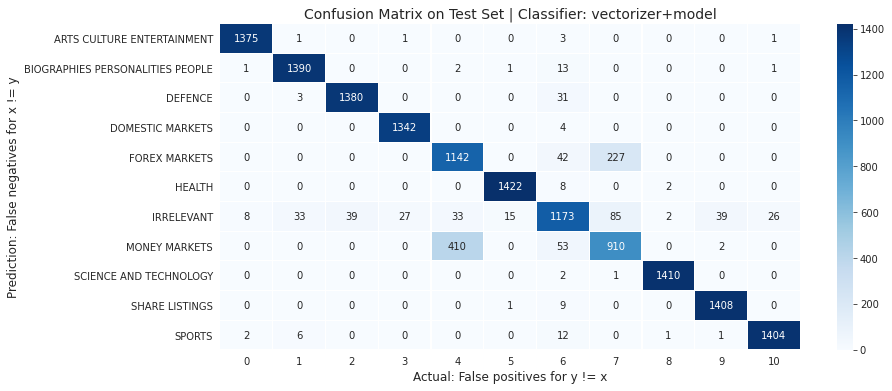

----------------------------------------------------------------------
Now, the train_df is train50, the validation_df is valid100
F1 score for  Pipeline  model is  0.9213759989841801
Accuracy score for  Pipeline  model is  0.921891124871001
Recall score for  Pipeline  model is  0.9221224746811812 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1381
           1       0.97      0.98      0.97      1408
           2       0.97      0.97      0.97      1414
           3       0.98      1.00      0.99      1346
           4       0.72      0.78      0.75      1411
           5       0.99      0.99      0.99      1432
           6       0.86      0.79      0.83      1480

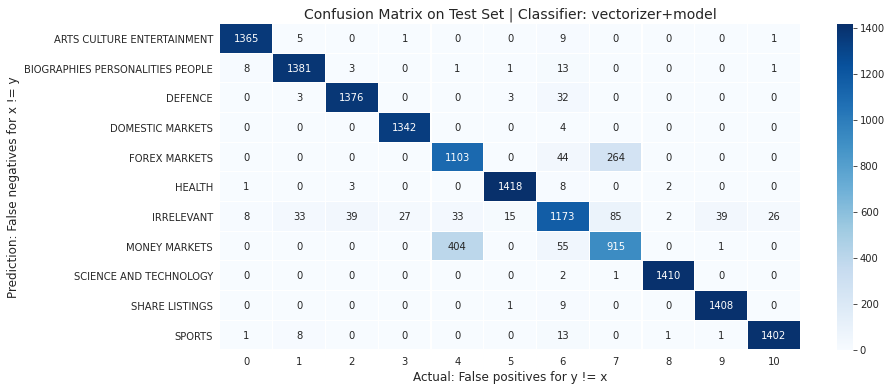

----------------------------------------------------------------------
Now, the train_df is train50, the validation_df is validfull
F1 score for  Pipeline  model is  0.9212665645809487
Accuracy score for  Pipeline  model is  0.9216976264189887
Recall score for  Pipeline  model is  0.9219499826378034 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1381
           1       0.96      0.98      0.97      1408
           2       0.97      0.96      0.97      1414
           3       0.98      1.00      0.99      1346
           4       0.72      0.80      0.76      1411
           5       0.98      0.99      0.99      1432
           6       0.85      0.79      0.82      14

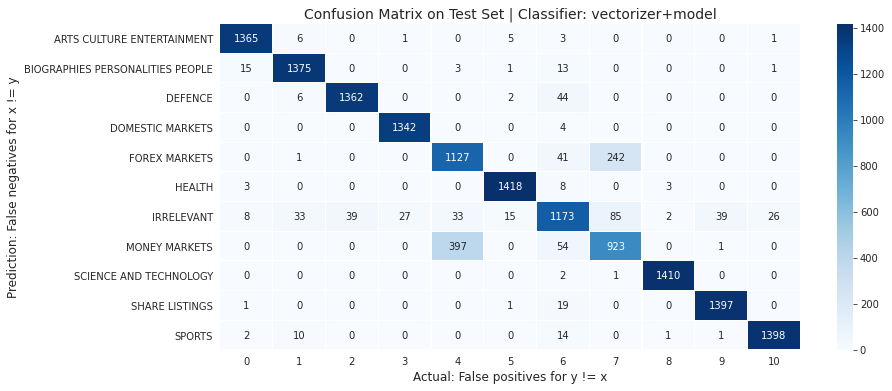

*************************************************************
Now the training set is train100, and the model chosen is count_clf_logi
The accuracy is 0.9365566188044203
----------------------------------------------------------------------
Now, the train_df is train100, the validation_df is valid10
F1 score for  Pipeline  model is  0.4134943810653207
Accuracy score for  Pipeline  model is  0.39493034055727555
Recall score for  Pipeline  model is  0.39426581934256233 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.21      0.34      1381
           1       0.75      0.26      0.38      1408
           2       1.00      0.15      0.26      1414
           3       0.64      0.77      0.7

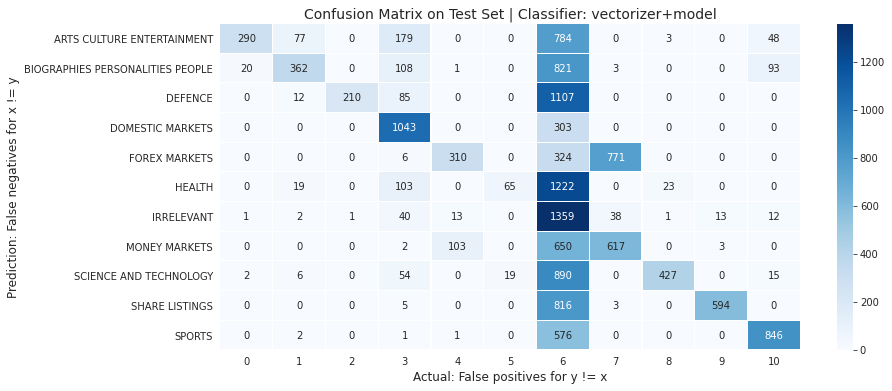

----------------------------------------------------------------------
Now, the train_df is train100, the validation_df is valid20
F1 score for  Pipeline  model is  0.6149633137618146
Accuracy score for  Pipeline  model is  0.5654669762641898
Recall score for  Pipeline  model is  0.5626123241044668 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.48      0.63      1381
           1       0.78      0.61      0.69      1408
           2       0.94      0.51      0.66      1414
           3       0.88      0.35      0.50      1346
           4       0.67      0.45      0.54      1411
           5       0.89      0.47      0.62      1432
           6       0.21      0.91      0.34      148

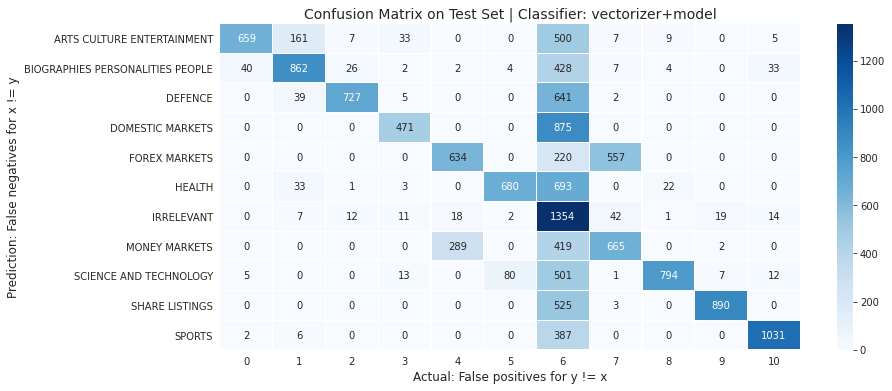

----------------------------------------------------------------------
Now, the train_df is train100, the validation_df is valid50
F1 score for  Pipeline  model is  0.8577507273563053
Accuracy score for  Pipeline  model is  0.8547471620227038
Recall score for  Pipeline  model is  0.8539369509688648 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1381
           1       0.87      0.91      0.89      1408
           2       0.95      0.94      0.94      1414
           3       0.97      0.88      0.92      1346
           4       0.71      0.72      0.72      1411
           5       0.95      0.94      0.94      1432
           6       0.59      0.82      0.69      148

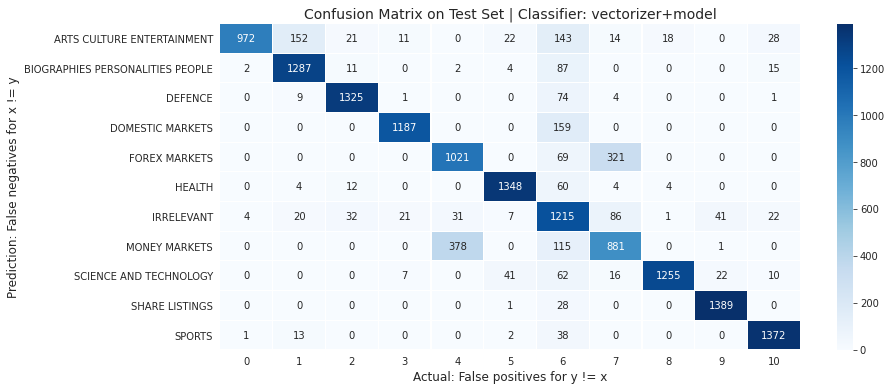

----------------------------------------------------------------------
Now, the train_df is train100, the validation_df is valid100
F1 score for  Pipeline  model is  0.9352434565143148
Accuracy score for  Pipeline  model is  0.9357585139318886
Recall score for  Pipeline  model is  0.9360213570708247 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1381
           1       0.98      0.99      0.99      1408
           2       0.98      0.98      0.98      1414
           3       0.98      1.00      0.99      1346
           4       0.75      0.82      0.79      1411
           5       0.99      1.00      0.99      1432
           6       0.90      0.81      0.85      14

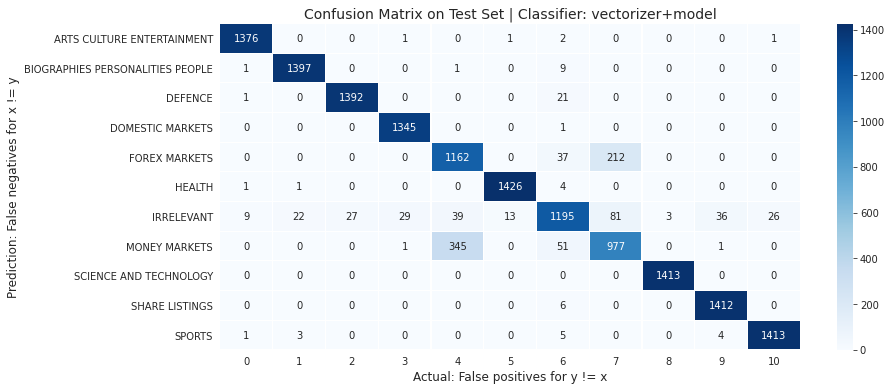

----------------------------------------------------------------------
Now, the train_df is train100, the validation_df is validfull
F1 score for  Pipeline  model is  0.9342530712040436
Accuracy score for  Pipeline  model is  0.9346620227038184
Recall score for  Pipeline  model is  0.9349444292744672 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1381
           1       0.98      0.99      0.98      1408
           2       0.98      0.98      0.98      1414
           3       0.98      1.00      0.99      1346
           4       0.75      0.82      0.78      1411
           5       0.99      1.00      0.99      1432
           6       0.89      0.81      0.85      1

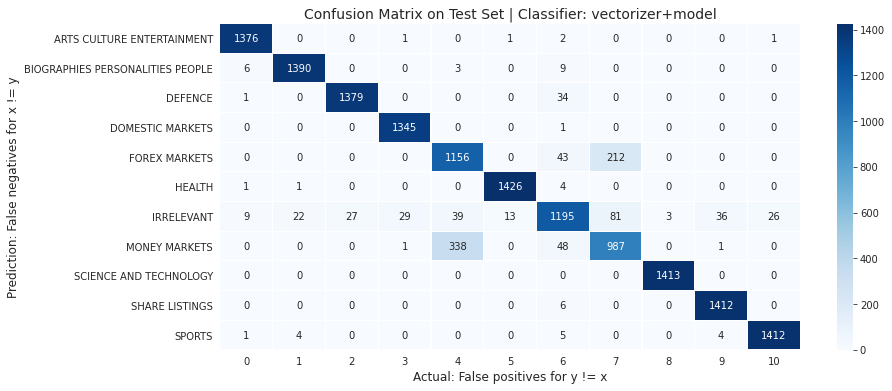

*************************************************************
Now the training set is trainfull, and the model chosen is tfidf_clf_logi
The accuracy is 0.9703655103281246
----------------------------------------------------------------------
Now, the train_df is trainfull, the validation_df is valid10
F1 score for  Pipeline  model is  0.32424207769103197
Accuracy score for  Pipeline  model is  0.34520123839009287
Recall score for  Pipeline  model is  0.34242142043007423 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      1381
           1       0.85      0.03      0.06      1408
           2       0.97      0.19      0.31      1414
           3       0.74      0.23      

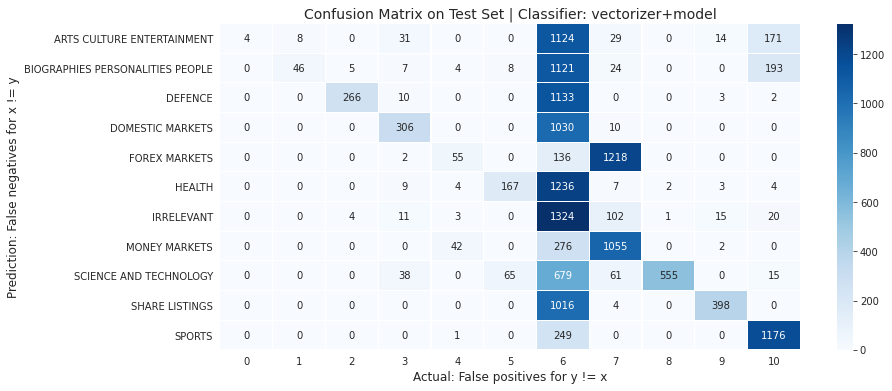

----------------------------------------------------------------------
Now, the train_df is trainfull, the validation_df is valid20
F1 score for  Pipeline  model is  0.4047999641191472
Accuracy score for  Pipeline  model is  0.39647832817337464
Recall score for  Pipeline  model is  0.39284328481690395 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.13      0.23      1381
           1       0.81      0.20      0.32      1408
           2       0.93      0.43      0.58      1414
           3       0.92      0.10      0.17      1346
           4       0.60      0.07      0.12      1411
           5       0.70      0.25      0.37      1432
           6       0.15      0.90      0.26      

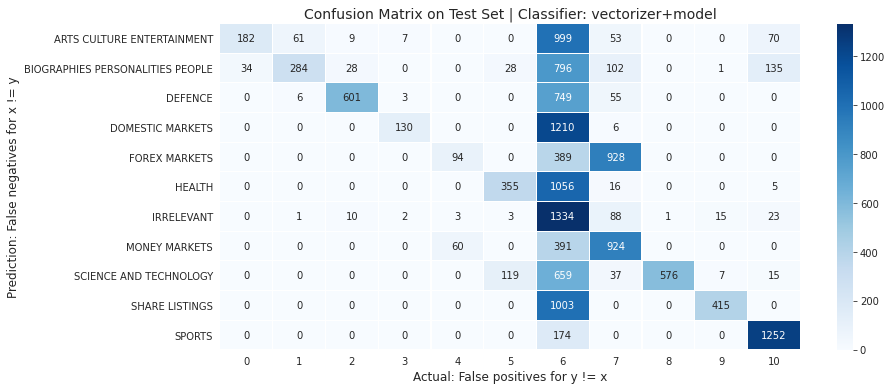

----------------------------------------------------------------------
Now, the train_df is trainfull, the validation_df is valid50
F1 score for  Pipeline  model is  0.5740290517592714
Accuracy score for  Pipeline  model is  0.5661764705882353
Recall score for  Pipeline  model is  0.5627024067120832 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.15      0.25      1381
           1       0.86      0.36      0.51      1408
           2       0.93      0.71      0.80      1414
           3       0.96      0.25      0.39      1346
           4       0.62      0.30      0.40      1411
           5       0.80      0.49      0.61      1432
           6       0.23      0.85      0.36      14

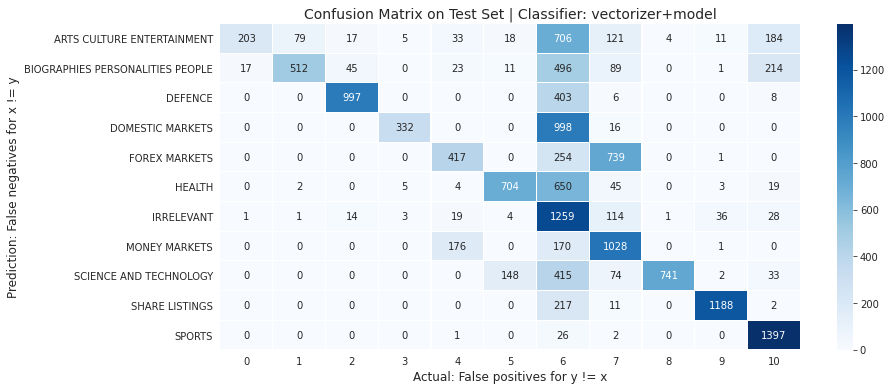

----------------------------------------------------------------------
Now, the train_df is trainfull, the validation_df is valid100
F1 score for  Pipeline  model is  0.6504669056732436
Accuracy score for  Pipeline  model is  0.6231940144478845
Recall score for  Pipeline  model is  0.6205681470159733 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.39      0.55      1381
           1       0.91      0.45      0.60      1408
           2       0.95      0.72      0.82      1414
           3       0.98      0.38      0.55      1346
           4       0.70      0.26      0.37      1411
           5       0.87      0.53      0.66      1432
           6       0.23      0.87      0.37      1

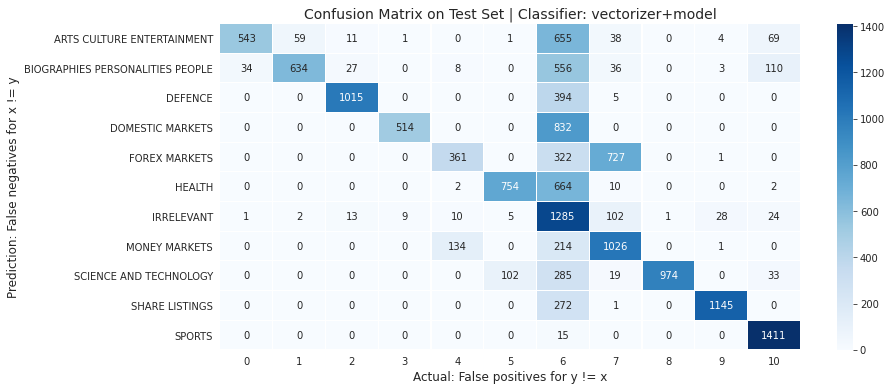

----------------------------------------------------------------------
Now, the train_df is trainfull, the validation_df is validfull
F1 score for  Pipeline  model is  0.9716847652046853
Accuracy score for  Pipeline  model is  0.9718137254901961
Recall score for  Pipeline  model is  0.9722720324723249 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1381
           1       0.99      1.00      0.99      1408
           2       0.98      1.00      0.99      1414
           3       0.99      1.00      1.00      1346
           4       0.90      0.95      0.93      1411
           5       0.99      1.00      1.00      1432
           6       0.97      0.85      0.91      

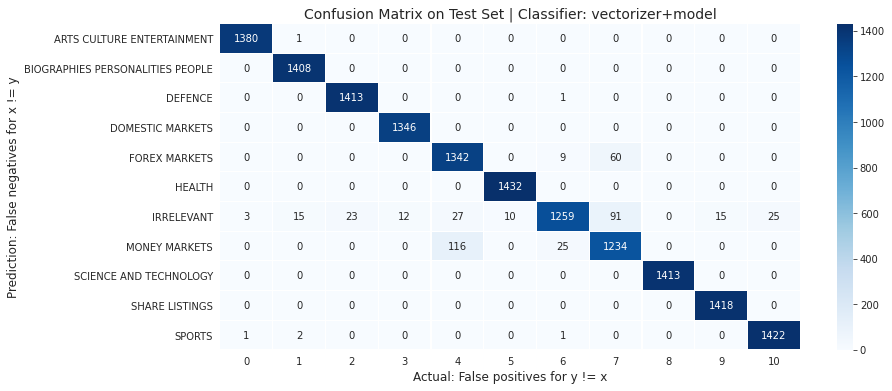

CPU times: user 4min 14s, sys: 1min 11s, total: 5min 26s
Wall time: 5h 35min 58s


In [13]:
%%time
rev_valid_y = le.inverse_transform(valid_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
for train_name, x_train in train_collection.items():
        clf_logi = get_model(train_name, x_train, train_y)
        for valid_name, x_valid in valid_collection.items():
            if (x_valid.isnull().values.any()):
                continue
            print('----------------------------------------------------------------------')
            print(f'Now, the train_df is {train_name}, the validation_df is {valid_name}')
            df_valid = pd.DataFrame({'key_word':x_valid,'topic':rev_valid_y})
            test_model(df_valid,clf_logi,le,encode_mapping)